In [13]:
import pandas as pd  #import dependencies
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import numpy as np
from collections import Counter
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

#set visualization styles of this
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12,8)

In [2]:
#Load dataset form Hugging Face
print("Loading medical tanscriptions - dataset !")
dataset = load_dataset("hpe-ai/medical-cases-classification-tutorial")
print(dataset)

#convert to the pandas dataframes - (training ,validations and testing )
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

print("Dataset Loaded sucessfuly ✅!")

print(f"Training set :{len(train_df)}")
print(f"Validation set:{len(val_df)}")
print(f"test set:{len(val_df)}")

print(f"Total sets:{len(train_df)+len(val_df)+len(test_df)}")



Loading medical tanscriptions - dataset !


Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    train: Dataset({
        features: ['description', 'transcription', 'sample_name', 'medical_specialty', 'keywords'],
        num_rows: 1724
    })
    validation: Dataset({
        features: ['description', 'transcription', 'sample_name', 'medical_specialty', 'keywords'],
        num_rows: 370
    })
    test: Dataset({
        features: ['description', 'transcription', 'sample_name', 'medical_specialty', 'keywords'],
        num_rows: 370
    })
})
Dataset Loaded sucessfuly ✅!
Training set :1724
Validation set:370
test set:370
Total sets:2464


In [3]:
#Display basic information about this dataset
print("Dataset stucture :")
print(train_df.info())
print("\n display first few rows :")
print(train_df.head())

Dataset stucture :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1724 entries, 0 to 1723
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        1724 non-null   object
 1   transcription      1724 non-null   object
 2   sample_name        1724 non-null   object
 3   medical_specialty  1724 non-null   object
 4   keywords           1109 non-null   object
dtypes: object(5)
memory usage: 67.5+ KB
None

 display first few rows :
                                         description  \
0  Pacemaker ICD interrogation.  Severe nonischem...   
1  Erythema of the right knee and leg, possible s...   
2  Left cardiac catheterization with selective ri...   
3  Patient with a history of coronary artery dise...   
4  Cardiac evaluation and treatment in a patient ...   

                                       transcription  \
0  PROCEDURE NOTE: , Pacemaker ICD interrogation....   
1  PREOPERATIVE DIAGNOSE

In [4]:
#Column anlysis and their data types 
print("column Anlysis .!")
for col in train_df.columns:
    print(f"\n{col}:")
    print(f"  Data type: {train_df[col].dtype}")
    print(f"  Non-null values: {train_df[col].count()}/{len(train_df)}")
    if train_df[col].dtype == 'object':
        print(f"  Unique values: {train_df[col].nunique()}")
        if col == 'medical_specialty':
            print(f"  Categories: {sorted(train_df[col].unique())}")

column Anlysis .!

description:
  Data type: object
  Non-null values: 1724/1724
  Unique values: 1259

transcription:
  Data type: object
  Non-null values: 1724/1724
  Unique values: 1263

sample_name:
  Data type: object
  Non-null values: 1724/1724
  Unique values: 1294

medical_specialty:
  Data type: object
  Non-null values: 1724/1724
  Unique values: 13
  Categories: ['Cardiovascular / Pulmonary', 'ENT - Otolaryngology', 'Gastroenterology', 'Hematology - Oncology', 'Nephrology', 'Neurology', 'Neurosurgery', 'Obstetrics / Gynecology', 'Ophthalmology', 'Orthopedic', 'Pediatrics - Neonatal', 'Psychiatry / Psychology', 'Radiology']

keywords:
  Data type: object
  Non-null values: 1109/1724
  Unique values: 971


In [5]:
# Analyze target variable distribution across all splits
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

specialty_counts = combined_df['medical_specialty'].value_counts()
print("Medical Specialty Distribution:")
print(specialty_counts)
print(f"\nTotal specialties: {len(specialty_counts)}")
print(f"Most common: {specialty_counts.index[0]} ({specialty_counts.iloc[0]} cases)")
print(f"Least common: {specialty_counts.index[-1]} ({specialty_counts.iloc[-1]} cases)")
print(f"Imbalance ratio: {specialty_counts.iloc[0] / specialty_counts.iloc[-1]:.2f}:1")

Medical Specialty Distribution:
medical_specialty
Cardiovascular / Pulmonary    742
Orthopedic                    408
Neurology                     282
Gastroenterology              222
Obstetrics / Gynecology       182
Hematology - Oncology         120
Neurosurgery                  109
ENT - Otolaryngology           80
Nephrology                     71
Psychiatry / Psychology        68
Ophthalmology                  66
Pediatrics - Neonatal          64
Radiology                      50
Name: count, dtype: int64

Total specialties: 13
Most common: Cardiovascular / Pulmonary (742 cases)
Least common: Radiology (50 cases)
Imbalance ratio: 14.84:1


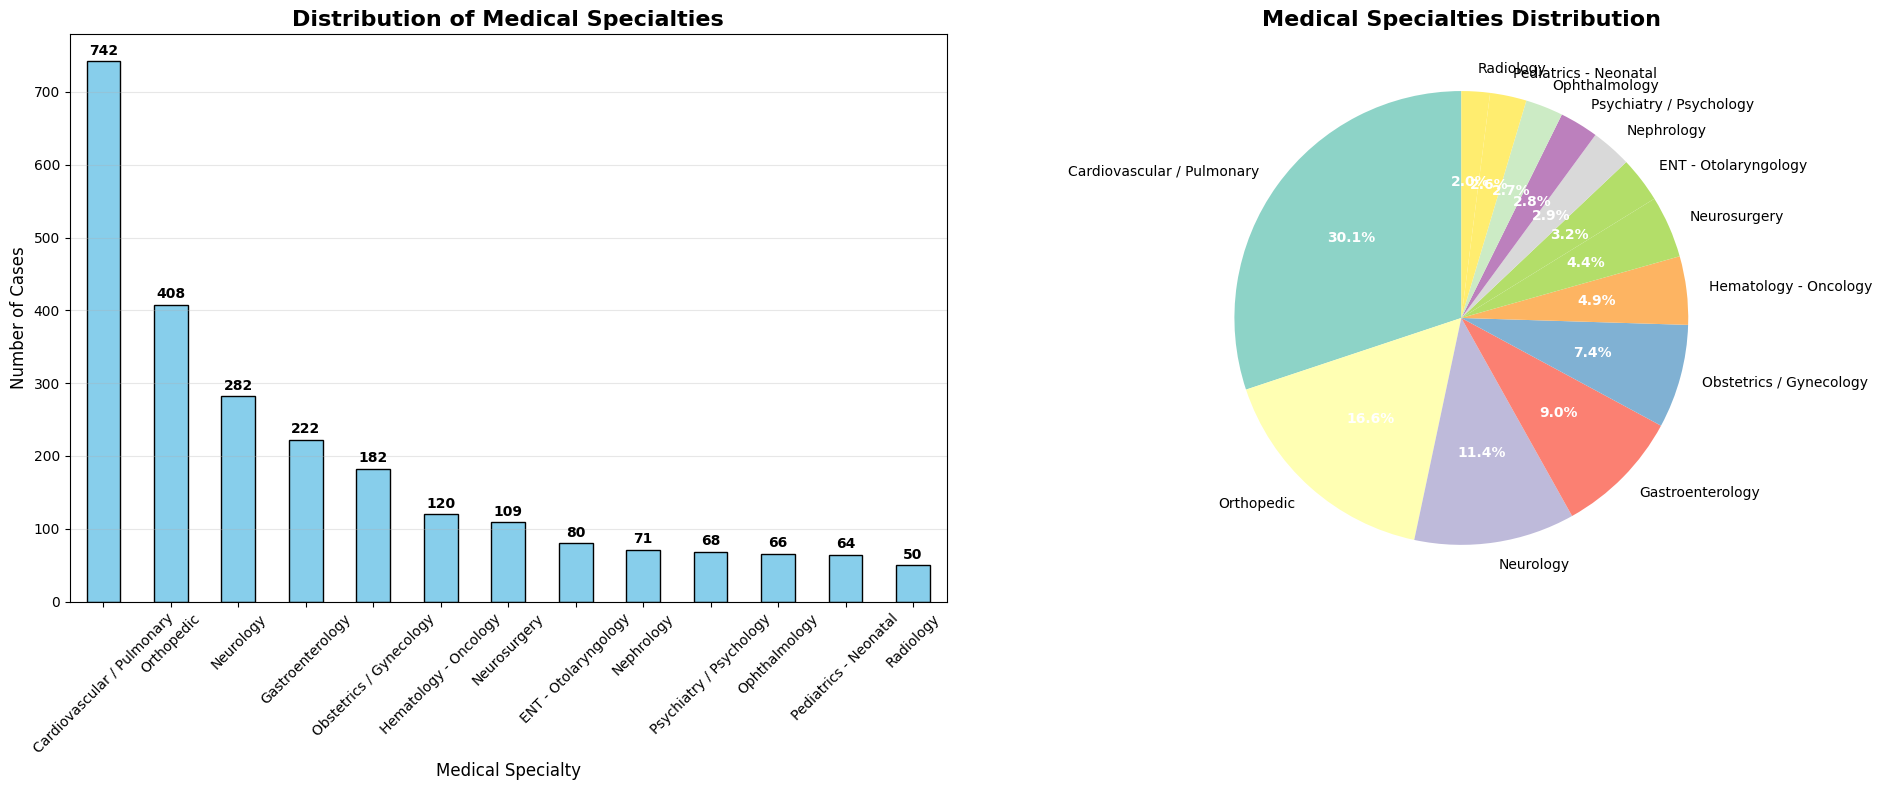

In [6]:
# Visualize class distribution in (Bar chart and Pie chart)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# ---Bar chart---
specialty_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Medical Specialties', fontsize=16, fontweight='bold')
ax1.set_xlabel('Medical Specialty', fontsize=12)
ax1.set_ylabel('Number of Cases', fontsize=12)
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(specialty_counts.values):
    ax1.text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

# ---Pie chart---
colors = plt.cm.Set3(np.linspace(0, 1, len(specialty_counts)))
wedges, texts, autotexts = ax2.pie(specialty_counts.values, 
                                   labels=specialty_counts.index,
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90)
ax2.set_title('Medical Specialties Distribution', fontsize=16, fontweight='bold')

# Improve pie chart readability
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()    

In [7]:
#Text Baesd analysis

#analyze text length characteristics
def analyze_text_lengths(df, text_column, title):
    lengths = df[text_column].str.len()
    word_counts = df[text_column].str.split().str.len()
    
    print(f"\n{title} Analysis:")
    print(f"Character length - Mean: {lengths.mean():.0f}, Median: {lengths.median():.0f}")
    print(f"Character length - Min: {lengths.min()}, Max: {lengths.max()}")
    print(f"Word count - Mean: {word_counts.mean():.0f}, Median: {word_counts.median():.0f}")
    print(f"Word count - Min: {word_counts.min()}, Max: {word_counts.max()}")
    
    return lengths, word_counts

# Analyze in transcription and description fields
trans_lengths, trans_words = analyze_text_lengths(combined_df, 'transcription', 'Transcription')
desc_lengths, desc_words = analyze_text_lengths(combined_df, 'description', 'Description')



Transcription Analysis:
Character length - Mean: 3319, Median: 2852
Character length - Min: 13, Max: 15216
Word count - Mean: 503, Median: 427
Word count - Min: 1, Max: 2460

Description Analysis:
Character length - Mean: 140, Median: 124
Character length - Min: 14, Max: 491
Word count - Mean: 20, Median: 16
Word count - Min: 2, Max: 76


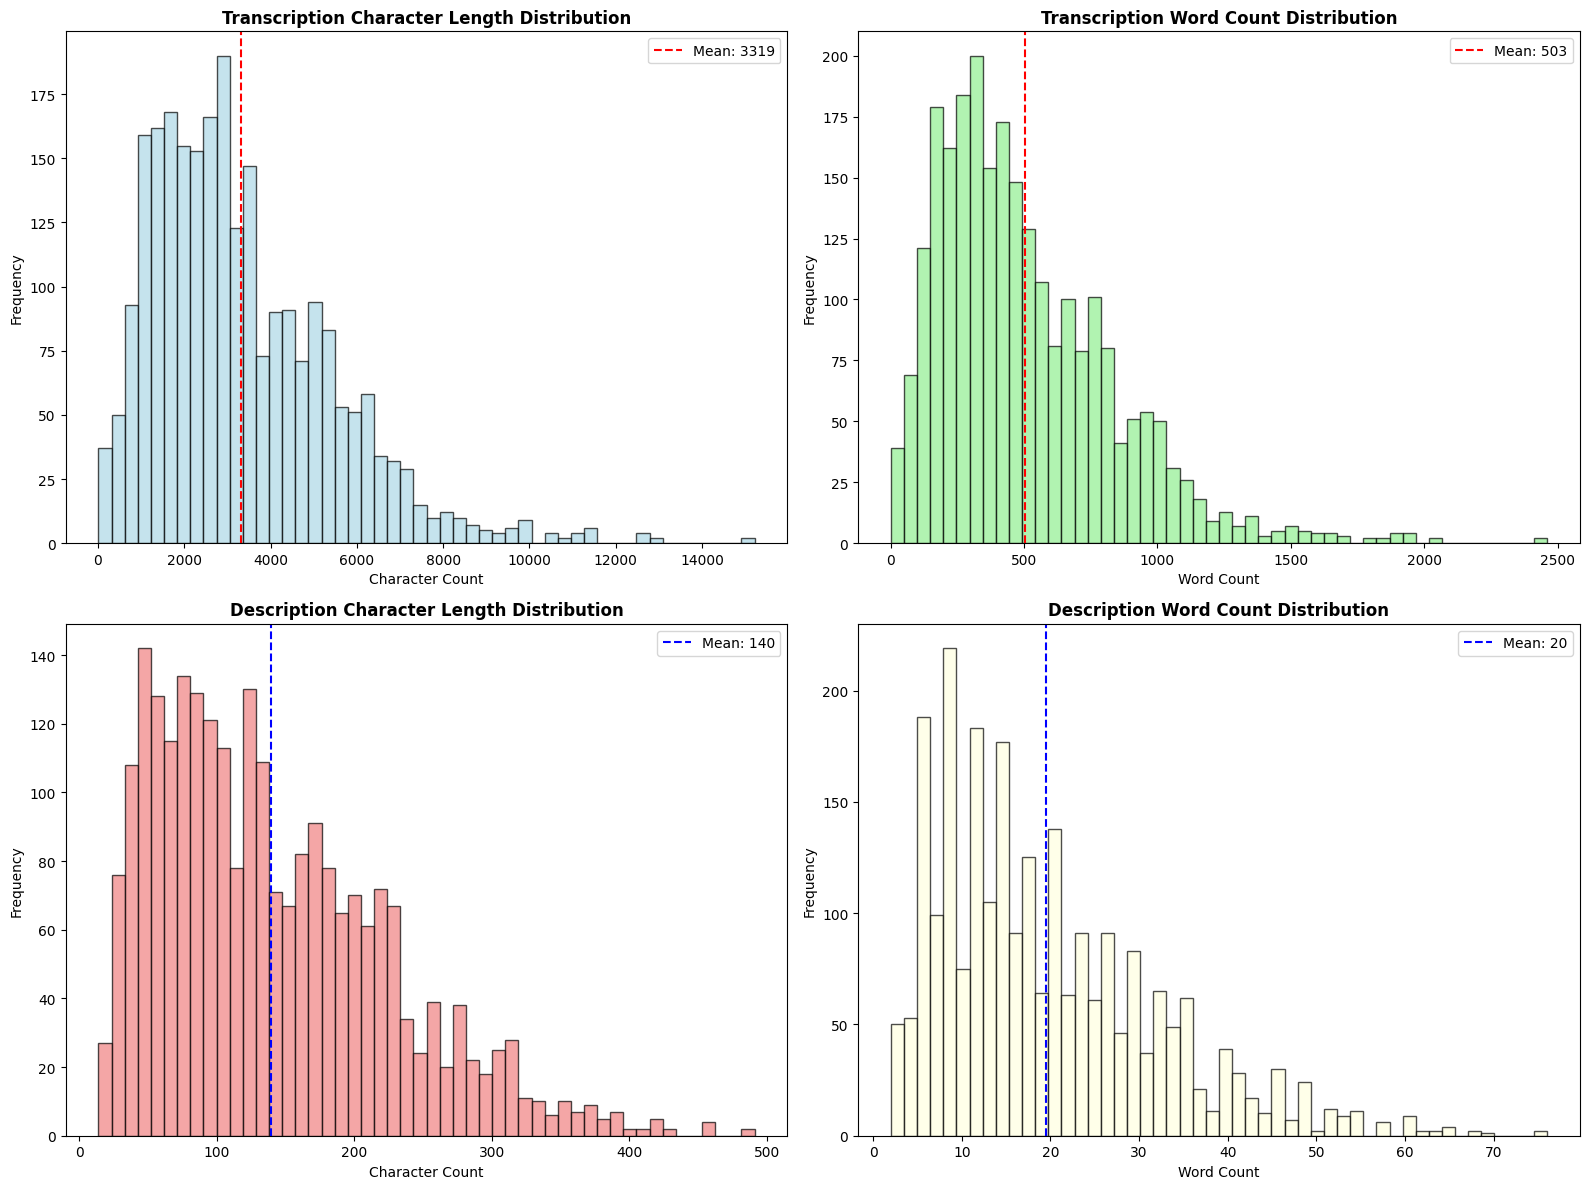

In [8]:
#Visualize Text based analysis 
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Transcription character lengths
axes[0, 0].hist(trans_lengths, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[0, 0].set_title('Transcription Character Length Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(trans_lengths.mean(), color='red', linestyle='--', label=f'Mean: {trans_lengths.mean():.0f}')
axes[0, 0].legend()

# Transcription word counts
axes[0, 1].hist(trans_words, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Transcription Word Count Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(trans_words.mean(), color='red', linestyle='--', label=f'Mean: {trans_words.mean():.0f}')
axes[0, 1].legend()

# Description character lengths
axes[1, 0].hist(desc_lengths, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Description Character Length Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Character Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(desc_lengths.mean(), color='blue', linestyle='--', label=f'Mean: {desc_lengths.mean():.0f}')
axes[1, 0].legend()

# Description word counts
axes[1, 1].hist(desc_words, bins=50, alpha=0.7, color='lightyellow', edgecolor='black')
axes[1, 1].set_title('Description Word Count Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(desc_words.mean(), color='blue', linestyle='--', label=f'Mean: {desc_words.mean():.0f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [9]:
# Analyze text lengths by medical specialty
specialty_text_stats = combined_df.groupby('medical_specialty').agg({
    'transcription': [lambda x: x.str.len().mean(), lambda x: x.str.split().str.len().mean()],
    'description': [lambda x: x.str.len().mean(), lambda x: x.str.split().str.len().mean()]
}).round(0)
specialty_text_stats.columns = ['Trans_Char_Avg', 'Trans_Word_Avg', 'Desc_Char_Avg', 'Desc_Word_Avg']
specialty_text_stats = specialty_text_stats.sort_values('Trans_Word_Avg', ascending=False)

print("Average Text Lengths by Medical Specialty:")
print(specialty_text_stats)

Average Text Lengths by Medical Specialty:
                            Trans_Char_Avg  Trans_Word_Avg  Desc_Char_Avg  \
medical_specialty                                                           
Psychiatry / Psychology             5431.0           849.0          113.0   
Neurosurgery                        4067.0           630.0          182.0   
Orthopedic                          3859.0           592.0          150.0   
Neurology                           3676.0           564.0          125.0   
Pediatrics - Neonatal               3706.0           556.0          100.0   
Nephrology                          3309.0           512.0          115.0   
ENT - Otolaryngology                3365.0           508.0          118.0   
Obstetrics / Gynecology             3234.0           488.0          135.0   
Radiology                           3183.0           463.0           79.0   
Hematology - Oncology               2947.0           451.0          154.0   
Cardiovascular / Pulmonary       

In [10]:
#Word frequency analysis

# Function to clean and extract words
def extract_words(text):
    if pd.isna(text):
        return []
    # Convert to lowercase and extract words (letters only)
    words = re.findall(r'\b[a-zA-Z]+\b', text.lower())
    # Filter out very short words
    return [word for word in words if len(word) > 2]

# Extract all words from transcriptions
all_words = []
for text in combined_df['transcription']:
    all_words.extend(extract_words(text))

# Get most common words
word_freq = Counter(all_words)
print(f"Total unique words: {len(word_freq)}")
print(f"Total words: {len(all_words)}")
print("\nTop 20 most common words:")
for word, count in word_freq.most_common(20):
    print(f"{word}: {count}")    

Total unique words: 17405
Total words: 1032883

Top 20 most common words:
the: 77705
and: 44529
was: 37941
with: 19320
patient: 11817
she: 9927
for: 9071
were: 8399
this: 7333
left: 6824
right: 6821
then: 6323
has: 5935
that: 5539
her: 5415
there: 5377
history: 5222
had: 4566
his: 4261
normal: 4071


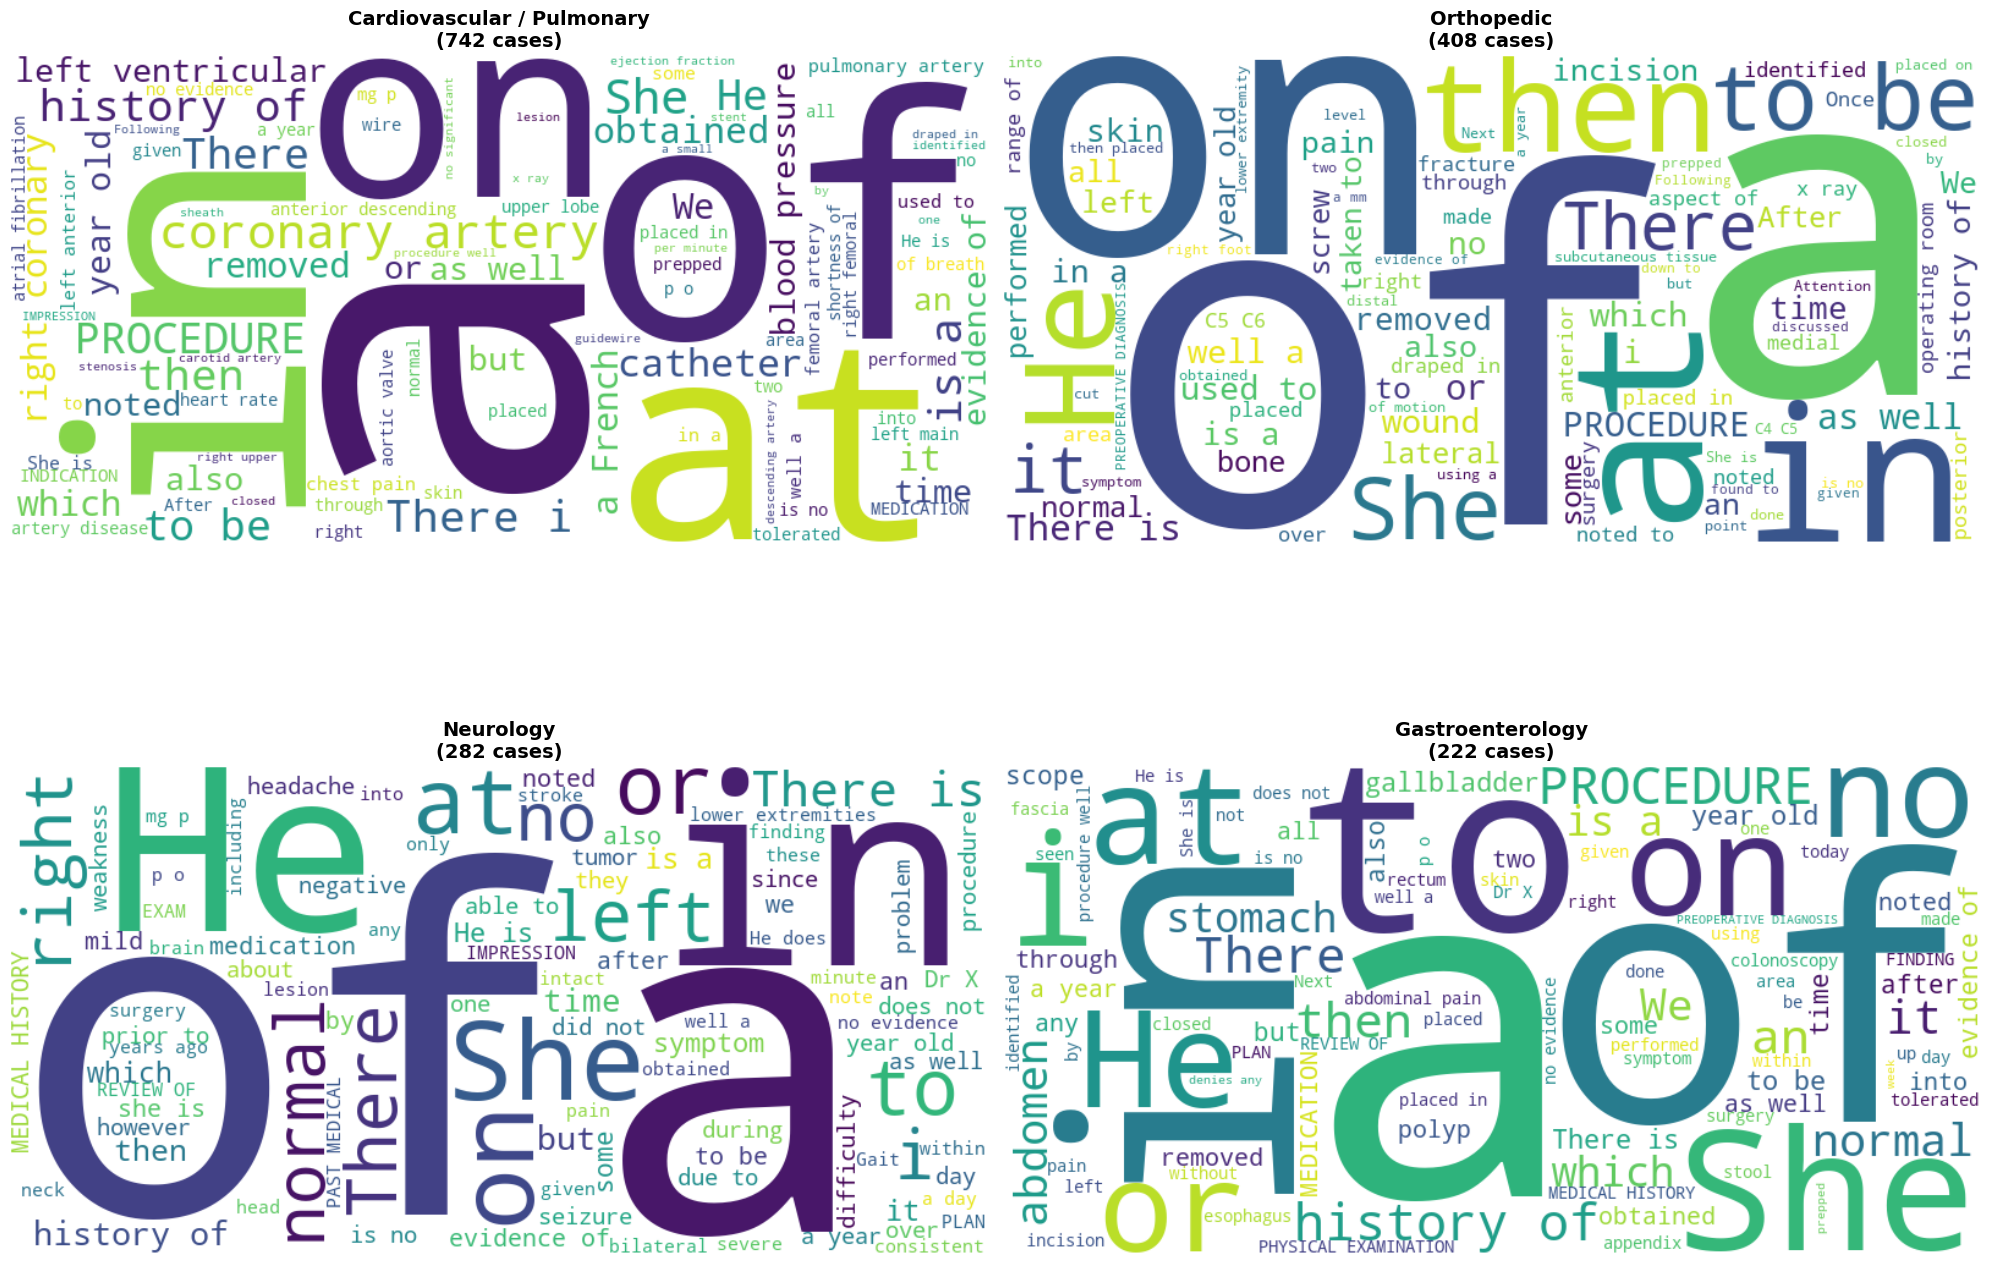

In [11]:
# Create word clouds for top medical specialties
top_specialties = specialty_counts.head(4).index

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

for i, specialty in enumerate(top_specialties):
    # Get all text for this specialty
    specialty_text = ' '.join(combined_df[combined_df['medical_specialty'] == specialty]['transcription'].fillna(''))
    
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         max_words=100,
                         colormap='viridis',
                         stopwords=set(['patient', 'the', 'and', 'with', 'was', 'for', 'had', 'his', 'her', 'this', 'that', 'from', 'were', 'been', 'have', 'has', 'are', 'will', 'would'])
                         ).generate(specialty_text)
    
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'{specialty}\n({specialty_counts[specialty]} cases)', 
                     fontsize=14, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [12]:
#Speciality Word analysis

# Analyze top words by specialty
def get_specialty_keywords(df, specialty, top_n=10):
    specialty_texts = df[df['medical_specialty'] == specialty]['transcription'].fillna('')
    specialty_words = []
    
    for text in specialty_texts:
        specialty_words.extend(extract_words(text))
    
    specialty_freq = Counter(specialty_words)
    return specialty_freq.most_common(top_n)

# Get keywords for each specialty
print("Top Keywords by Medical Specialty:")
print("=" * 50)

for specialty in sorted(combined_df['medical_specialty'].unique()):
    keywords = get_specialty_keywords(combined_df, specialty, 8)
    keyword_list = [f"{word}({count})" for word, count in keywords]
    print(f"\n{specialty}:")
    print(", ".join(keyword_list))

Top Keywords by Medical Specialty:

Cardiovascular / Pulmonary:
the(20638), and(10706), was(9886), with(5124), patient(3324), left(3100), right(2600), for(2330)

ENT - Otolaryngology:
the(3091), and(1527), was(1271), with(717), patient(454), then(316), were(311), this(292)

Gastroenterology:
the(5659), and(3160), was(2773), with(1388), patient(1022), she(703), for(666), were(591)

Hematology - Oncology:
the(2554), and(1738), was(1133), with(815), she(721), history(497), for(494), has(491)

Nephrology:
the(1888), and(1157), was(818), with(469), patient(335), for(300), his(283), has(277)

Neurology:
the(6822), and(5610), was(3137), she(2221), with(1950), for(1310), her(1266), that(1156)

Neurosurgery:
the(5712), and(2936), was(2891), with(1266), were(723), then(664), this(574), patient(533)

Obstetrics / Gynecology:
the(6774), was(3909), and(3535), with(1780), were(890), patient(857), she(809), then(775)

Ophthalmology:
the(2244), was(1229), and(970), with(506), eye(365), were(272), pati